# libCEED FEM Pareto Analysis

In [204]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib
from IPython.display import Image
from IPython.core.display import HTML 

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.size'] = 16

#### Finite Element Method (FEM) are based on the approximation of a field/function.
#### Approximation by summation of basis functions ($\phi(x)$) with discrete nodal values.
* Most basis functions are polynomial based


$$f(x) \approx \sum^{N_{nodes}}_{i=1} \phi_i(x) n_i$$

In [246]:
Image(url= "http://hplgit.github.io/INF5620/doc/pub/sphinx-fem/_images/fe_mesh1D_phi_i_f.png", width=800)

In [180]:
Image(url= "https://www.doitpoms.ac.uk/tlplib/fem/images/interpolation_image.jpg", width=1200)

#### Increasing accuracy done by:
* Increasing number of nodes
* Increasing polynomial (basis) order

In [185]:
# Image(url= "http://hplgit.github.io/INF5620/doc/pub/sphinx-fem/_images/fe_p1_x2_2e_4e.png", width=1200)

In [184]:
Image(url= "http://hplgit.github.io/INF5620/doc/pub/sphinx-fem/_images/fe_p1_p2_x9_248e.png", width=1000)

Upper Left: 5 dofs, linear

Upper Right: 5 dofs, quadratic

Lower Left: 9 dofs, linear

Lower Right: 9 dofs, quadratic

### Computational considerations:

#### Increasing number of nodes
* Increases size of $\mathbb{A}$ matrix in $\mathbb{A}\mathbf{x} = \mathbf{b}$

#### Increasing polynomial (basis) order
* Increases width of "stencile"
* Causes $\mathbb{A}$ to be more dense, $\therefore$ more expensive to solve

**These considerations form a trade-off between accuracy, cost, and speed**

In [248]:
Image(url= "http://hplgit.github.io/INF5620/doc/pub/sphinx-fem/_images/mpl_fe_basis_p3_4e.png", width=800)

Cubic basis functions. Note how they span over several nodes.

### Problem Desciption
* Fluid Flow problem (Navier-Stokes equations)
* Advection of a thermal bubble in a vortex




### Error Metric
* Max error compared to exact solution

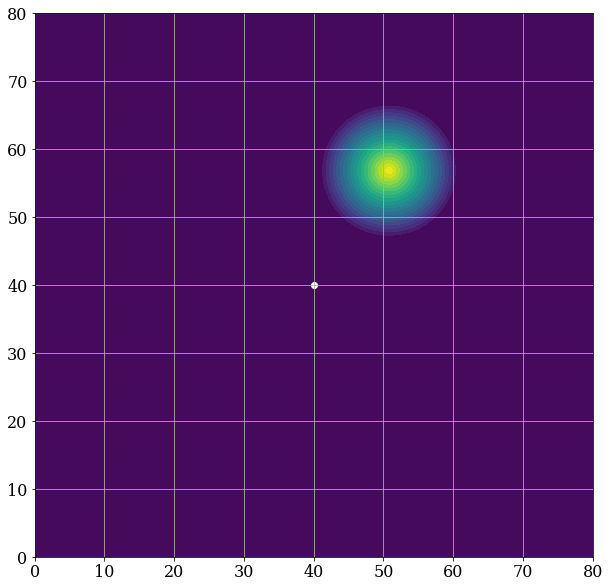

In [244]:
%run advection_error.py
showSolutionContour(t=1)

In [218]:
# logreg = re.compile(r'(?:FLAG ARGUMENTS..((?:^\S+ = \S+$.)+)).*(?:Global FEM nodes: (\d{2,})).*(?:^Time taken for solution: (\d+\.?\d+)).*(?:^Max Error: (\d+\.?\d+))', re.M|re.S)
logreg = re.compile(r'(?:FLAG ARGUMENTS.((?:^\S+ = \S+$.)+)).*(?:^Global FEM nodes: (\d{2,})).*(?:^Time taken for solution: (\d+\.?\d+)).*(?:^Max Error: (\d+\.?\d+))', re.S|re.M)
runlogDir = Path('./runlogs/')
testfile = Path('./runlogs/1_45.log')

results = pd.DataFrame(columns=['degree', 'meshres', 'dofs', 'time', 'error'])
for file in runlogDir.glob('*.log'):
# for file in runlogDir.glob('1_45.log'):
    values = {}
    filenameMatch = re.match(r'.*(\d)_(\d+).log', file.as_posix())
    values['degree'], values['meshres'] = filenameMatch[1], filenameMatch[2]
    
    with file.open() as filer:
        filestring = filer.read()
    match = logreg.match(filestring)
    values['dofs'] = match[2]
    values['time'] = match[3]
    values['error'] = match[4]
    results = results.append(values, ignore_index=True)

    ## Regexing arguments for nsplex
#     args = match[1]
#     args = args.split('\n')
#     while("" in args): 
#         args.remove("") 
#     argdict = {}
#     for arg in args:
#         key, value = arg.split(' = ')
#         argdict[key] = value
        
# results = pd.to_numeric(results,errors='coerce') 
# print(results)
results = results.apply(lambda row: pd.to_numeric(row, errors='coerce'))
results.sort_values(['degree', 'dofs'])
results.groupby(['degree', 'dofs']).first().style.background_gradient(cmap='viridis')

In [207]:
plotkwargs = [{'marker':'>', 'linestyle':'dashed', 'label': 'deg: 1'}, 
             {'marker':'s', 'linestyle':'dashed', 'label': 'deg: 2'}, 
             {'marker':'o', 'linestyle':'dashed', 'label': 'deg: 3'}]

def plotResults(xaxis, yaxis, xlog=True, ylog=True, nolog=False):
    xaxis = xaxis
    yaxis = yaxis
    for group in results.groupby('degree'):
        data = group[1]
        data = data.sort_values('dofs')
        ax.plot(data[xaxis], data[yaxis], **plotkwargs[int(group[0]) - 1])

    ax.legend()
    ax.set_xlabel(xaxis)
    ax.set_ylabel(yaxis)
    if not nolog:
        if ylog: ax.set_yscale('log')
        if xlog: ax.set_xscale('log')
    ax.set_title(xaxis + ' vs ' + yaxis)
    # plt.loglog()
    ax.grid()

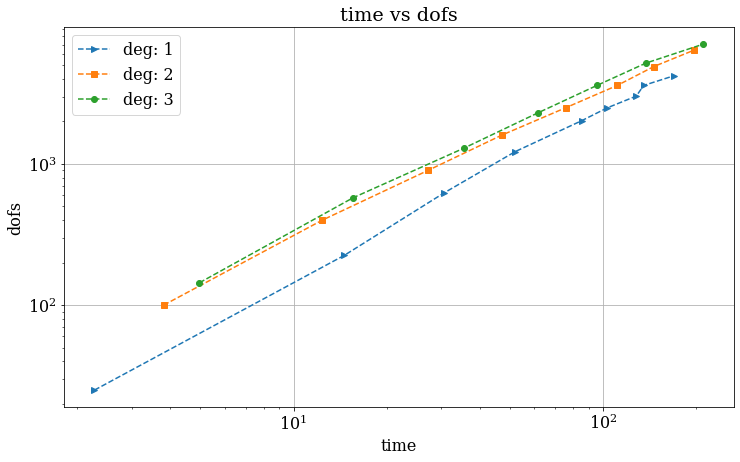

In [208]:
fig, ax = plt.subplots(figsize=[12,7])
plotResults('time', 'dofs')

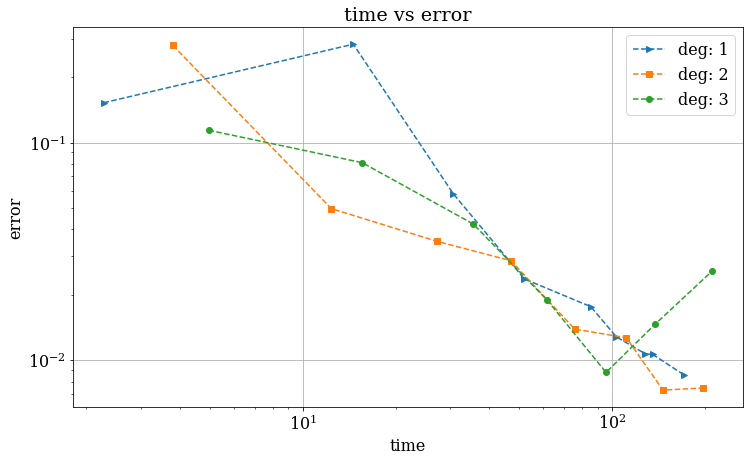

In [209]:
fig, ax = plt.subplots(figsize=[12,7])
plotResults('time', 'error')

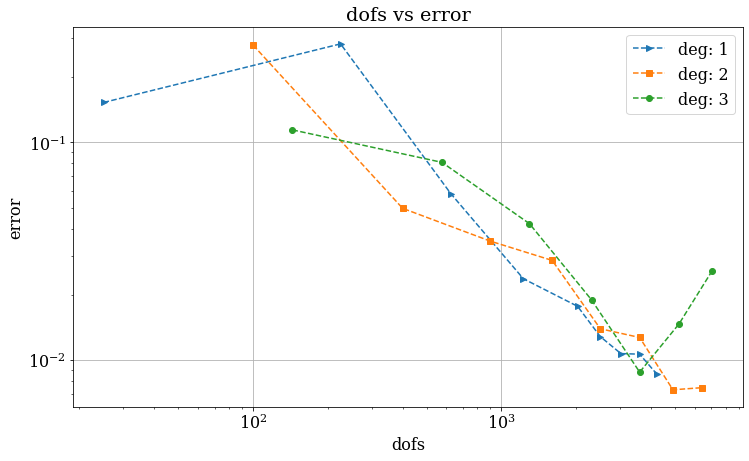

In [210]:
fig, ax = plt.subplots(figsize=[12,7])
plotResults('dofs', 'error')

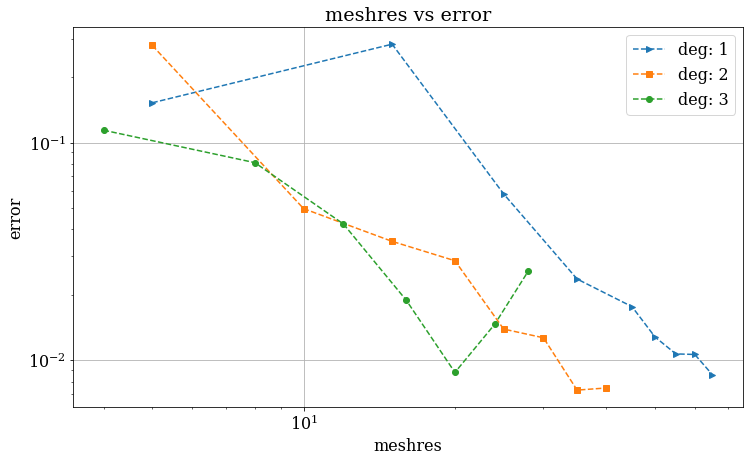

In [247]:
fig, ax = plt.subplots(figsize=[12,7])
plotResults('meshres', 'error')

### Possible Next Steps
#### 1) Investigate 3rd degree behavior
#### 2) Look at variance between runs
#### 3) Increase the numerical order accuracy

## Questions?